In [115]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow import keras
from keras import Sequential
from keras import layers
from keras.regularizers import L1L2
from keras import optimizers
import matplotlib.pyplot as plt
import plotly.express as px

In [116]:
## Config
k = 7
## Data
# abw = pd.read_csv("~/user/Downloads/sqllab_query_dispense_luaabwasser_lua_20220317T205021.csv").set_index("meldedatum").dropna().filter(("sum_7tage", "sum_14tage"))
abw = pd.read_csv(
    "~/user/Downloads/20220502_142656.csv", parse_dates=True
).rename(columns={"Abwasser 7T": "WW_7days", "Abwasser Täglich": "daily", "__timestamp": "Meldedatum"}).set_index("Meldedatum")
abw["WW_14days"] = abw["daily"].rolling(14, min_periods=1).sum()
abw["WW_28days"] = abw["daily"].rolling(28, min_periods=1).sum()
abw.index = pd.to_datetime(abw.index).strftime("%Y-%m-%d")
rki = pd.read_csv("Dresden_RKI_data.csv").set_index("Refdatum")
impf = pd.read_csv("Dresden_Impfungen.csv").set_index("Impfdatum")
var = pd.read_csv("Dresden_Varianten.csv").set_index("DATE_DRAW")
wet = pd.read_csv("Wetter_Dresden_seit2021.csv").set_index("date").filter(("prcp",))
# var["Omikron"] = var["BA.1"] + var["BA.2"]
df = abw.join(var).join(rki).join(impf).join(wet)
df[f"daily"] = df.loc[df.prcp < 5, f"daily"]
df.index = pd.to_datetime(df.index)
df = df.interpolate("time", axis=0)
df = df.fillna(method="ffill").fillna(method="bfill")
# df.index = pd.to_datetime(df.index)
# df.plot(figsize=(20,6))
px.line(df, title="Input Data")
# df.isna().any()


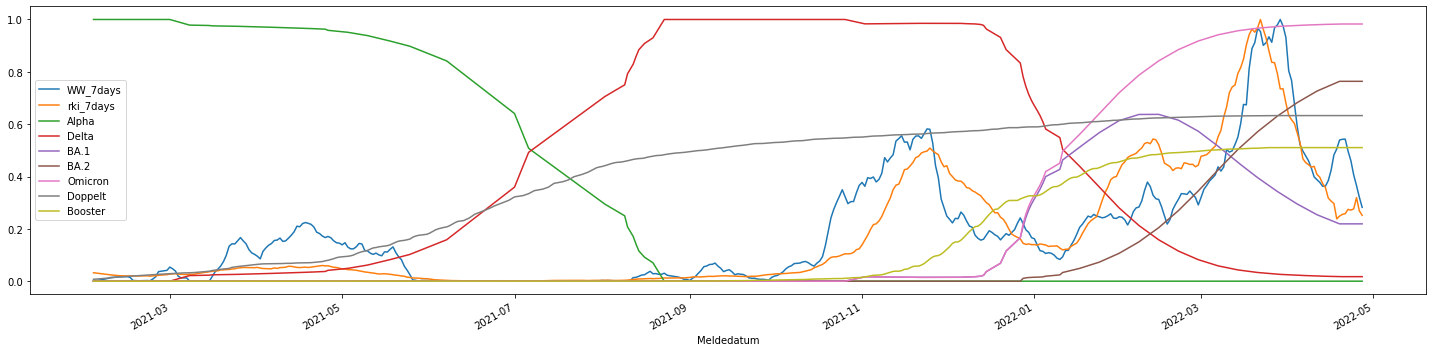

In [117]:
## Prepare windowed data
scaler = MinMaxScaler()
# df_scaled = df.copy().filter(("sum_14tage", "sum_7tage", "rki_14tage", "rki_7tage"))#, "Omikron"))
df_scaled = df.copy().filter((f"WW_{k}days",)).join(df.filter(regex=f"^rki_{k}\w+"))
df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns, index=df_scaled.index).join(df.filter(("Alpha", "Delta", "BA.1", "BA.2", "Omicron"))).join(df.filter(regex="(Booster|Doppelt).*"))
# df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns, index=df_scaled.index).join(df.filter(("Alpha", "Delta", "BA.1", "BA.2"))).join(df.filter(regex="(Booster|Doppelt).*"))
# df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns, index=df_scaled.index).join(df.filter(("Alpha", "Delta", "Omikron"))).join(df.filter(regex="(Booster|Doppelt).*"))
# df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns, index=df.index).join(df.drop(df.filter(regex=r"(\w+tage)").columns, axis=1))
X = np.array([win.values.transpose() for win in df_scaled.filter(regex=f"^(?!rki_{k}days)").rolling(30) if len(win) == 30][:-1])
y = np.array([win.values[-1] for win in df_scaled.filter((f"rki_{k}days",)).rolling(31) if len(win) == 31])
X_train, X_test, y_train, y_test = train_test_split(X[:-30,:,:], y[:-30,:], random_state=1) # exclude last 30 days
# X_train, X_test, y_train, y_test = train_test_split(X[:-14,:,:], y[:-14,:], random_state=1) # exclude last 14 days
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1) # exclude nothing
df_scaled.plot(figsize=(20, 5))
plt.tight_layout()
plt.savefig("machine_learning_input.png")
plt.show()
# px.line(df_scaled)


In [118]:
## LSTM
model = Sequential()
model.add(layers.LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2]), bias_regularizer=L1L2(l1=0.01, l2=0.01), recurrent_dropout=0.1))
# model.add(layers.LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(layers.LSTM(32, return_sequences=True))
# model.add(layers.LSTM(32, bias_regularizer=L1L2(l1=0.01, l2=0.01), recurrent_dropout=0.1))
# model.add(layers.Dropout(0.05))
model.add(layers.Dense(1))
model.compile(loss="mse", optimizer=optimizers.adam_v2.Adam(learning_rate=.005))
# model.compile(loss="mse", optimizer="Adam")
model.summary()


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 16)                3008      
                                                                 
 dense_23 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,025
Trainable params: 3,025
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
9/9 [==============================] - 3s 53ms/step - loss: 0.3377 - val_loss: 0.3211
Epoch 2/100
9/9 [==============================] - 0s 20ms/step - loss: 0.3078 - val_loss: 0.2971
Epoch 3/100
9/9 [==============================] - 0s 20ms/step - loss: 0.2859 - val_loss: 0.2776
Epoch 4/100
9/9 [==============================] - 0s 20ms/step - loss: 0.2657 - val_loss: 0.2576
Epoch 5/100
9/9 [==============================] - 0s 27ms/step - loss: 0.2470 - val_loss: 0.2390
Epoch 6/100
9/9 [==============================] - 0s 20ms/step - loss: 0.2288 - val_loss: 0.2224
Epoch 7/100
9/9 [==============================] - 0s 21ms/step - loss: 0.2118 - val_loss: 0.2061
Epoch 8/100
9/9 [==============================] - 0s 22ms/step - loss: 0.1952 - val_loss: 0.1909
Epoch 9/100
9/9 [==============================] - 0s 23ms/step - loss: 0.1804 - val_loss: 0.1758
Epoch 10/100
9/9 [==============================] - 0s 27ms/step - loss: 0.1653 - val_loss: 0.1609
Epoch 11/100
9/9 [=

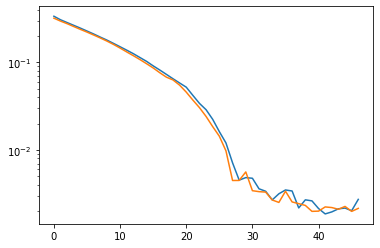

In [119]:
# fit network
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    # verbose=1,
    shuffle=False,
    callbacks=[callback]
)
plt.semilogy(pd.DataFrame(history.history))
plt.show()

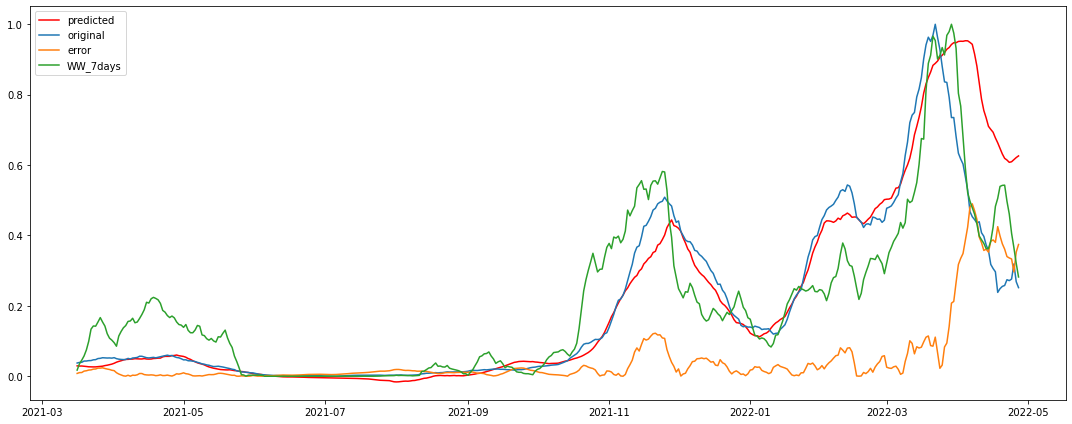

error: 0.05


In [120]:
pred = model.predict(X)
df_pred = df_scaled.copy()
df_pred["pred"] = np.pad(np.squeeze(pred), [X.shape[-1], 0], constant_values=np.nan)
df_pred[df_pred < 0] = 0
df_pred["error"] = df_pred["pred"] - df_pred[f"rki_{k}days"]
# df_pred.plot(figsize=(15,6), style={"pred": ".", "error": "-."})
# px.line(df_pred)
plt.figure(figsize=(15,6))
plt.plot(df_pred.index[30:], pred, "r")
plt.plot(df_pred.index[30:], y)
plt.plot(df_pred.index[30:], np.abs(pred-y))
plt.plot(df_pred.filter((f"WW_{k}days",)).iloc[30:])
plt.tight_layout()
plt.legend(("predicted", "original", "error", f"WW_{k}days"))
plt.savefig("machine_learning.png")
plt.show()
print(f"error: {np.mean(np.abs(pred-y)):.1g}")
# model.evaluate(X_test, y_test)

In [121]:
## Random forest
regr = RandomForestRegressor(n_estimators=200)#, max_depth=6, random_state=0)
X = df.filter(("geimpft", "sum_14tage", "sum_7tage", "Alpha", "BA.1", "BA.2", "Delta")).astype(float).values
y = df["lua_14tage"].astype(float).values
regr.fit(X,y)
df["prediction"] = regr.predict(X)
df.filter(("lua_14tage", "sum_14tage", "sum_7tage", "prediction", "Alpha", "BA.1", "BA.2", "Delta")).plot(secondary_y=("sum_14tage", "sum_7tage"), figsize=(15, 5), title="Random Forest")

KeyError: 'lua_14tage'

In [ ]:
## MLP
# print(y_train)
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
regr.predict(X_test[:2])
regr.score(X_test, y_test)